In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
%matplotlib inline
plt.rcParams["figure.figsize"] = (18.,9.)

In [180]:
def form_discrete_values(funcs, y, orders):
    """ This function is used to present values of a model (Ferhulst for example)
        in an apropriate view of the table with first columns, referring to x, and lthe last one 
        to y. THE FUNCTION WORKS ONLY IN CASE STEP OF DISCRETIZATION IS 1 (any atempts aimed at fixing that
        caused a general formula to change (that is, each model would require its own discretization function
        that is shit, I reckon))
        @Parameters:
        1) funcs - contains an array of lambdas, to be applied to columns
        2) y - a column with output values
        3) orders - an array of integers, used to refer to lagging (for example, orders = 2, means, that
        the column is considered to be y[t - 2])"""
    x = np.array([[funcs[j](y[t - orders[j], 0]) for j in range(len(funcs))] \
                  for t in range(orders[0], y.shape[0])])
    data = np.hstack((x, y[orders[0]:]))
    return data


class Approximator(object):
    """ @Parameters:
        1) data - a table, where first columns are features and the last one is output
        2) teta - unknown parameters to be evaluated
        3) variance - unknown variance to be found
        This class is used to get linear approximation (using OMNK algo) and
        to calculate thereby variance, Akaike and Mallows coefficients"""
    def __init__(self, data):
        self.data = data
        self.teta = None
        self.variance = 0
        
    def get_tetas(self, factors):
        """ @Parameters:
            1) factors - represents amount of factors to be accounter into (might not exceed the
            size of the self.data)
            This function implements OMNK algorithm, which recursively evaluates unknown coefficients
            by gradually adding columns to  X.T@X matrix and therefore requiring as much as there are
            columns present to complete. At the same time variance is also evalueted recursively"""
        n, m = self.data.shape
        Hs = np.array([[(self.data[:, 0].T @ self.data[:, 0])]])
        h = np.array([[self.data[:, 0] @ self.data[:, 1]]])
        eta = np.array([[self.data[:, 0].T @ self.data[:, 0]]])
        Hs_inv = np.linalg.inv(Hs)
        teta = [self.data[:, :1].T @ self.data[:, -1] / (self.data[:, :1].T @ self.data[:, :1])]
        P = np.eye(n) - (self.data[:, :1] @ np.linalg.inv(self.data[:, :1].T 
                                          @ self.data[:, :1]) @ self.data[:, :1].T)   
        variance = self.data[:, -1].T @ P @ self.data[:, -1]
        
        for i in range(1, factors):
            
            h = np.array([self.data[:, :i].T @ self.data[:, i]])
            eta = np.array([[self.data[:, i].T @ self.data[:, i]]])
            
            Hs_1 = Hs
            Hs_2 = h.T
            Hs_3 = h
            Hs_4 = eta
            beta = eta - h @ Hs_inv @ h.T
            
            D = np.eye(n) - self.data[:, :i] @ Hs_inv @ self.data[:, :i].T
            coefficient = self.data[:, i].T @ D @ self.data[:, i]
            variance -= (teta[-1] ** 2) * beta
            print(variance)
            
            Hs = np.hstack((np.vstack((Hs_1, Hs_3)), np.vstack((Hs_2, Hs_4))))

            Hs_inv_1 = Hs_inv + (1 / beta) * Hs_inv @ h.T @ h @ Hs_inv
            
            Hs_inv_2 = -(1 / beta) * Hs_inv @ h.T
            Hs_inv_3 = -(1 / beta) * h @ Hs_inv
            Hs_inv_4 = (1 / beta)
            
            Hs_inv = np.hstack((np.vstack((Hs_inv_1, Hs_inv_3)), np.vstack((Hs_inv_2, Hs_inv_4))))
            
            gs = np.hstack((self.data[:, :i].T @ self.data[:, -1], self.data[:, i].T @ self.data[:, -1]))
            
            teta = Hs_inv @ gs

        self.teta = teta
        self.variance = variance
        return teta
    
    def get_variance(self):
        return self.variance
    
    def get_sigma_evaluation(self):
        n, m = self.data.shape
        return self.variance / (n - m)
    
    def get_Mallows(self):
        n, m = self.data.shape
        return self.variance + self.get_sigma_evaluation() * (2 * m - n)
    
    def get_Akaike(self):
        n, m = self.data.shape
        return self.variance * ((n + m)/ (n - m))
    
    def get_params(self, formulas):
        params = list(map(lambda formula: formula(self.teta), formulas))
        return params

class Model:
    def __init__(self, system):
        self.system = system
        self.solved = None
        self.time_points = None
        self.initial_condition = None
        self.params = None
    
    def get_values(self, step):
        data = self.solved[:, 0][::step]
        return data.reshape((data.shape[0], 1))
    
    def build(self, params, initial_condition, time_points):
        self.params = params
        self.time_points = time_points
        self.initial_condition = initial_condition
        self.solved = odeint(self.system, initial_condition, time_points, args=params)
            
    def get_data(self, index):
        if index == 0:
            return pd.DataFrame({'t': self.time_points, 'X(t)': self.solved[:, 0]})
        if index == 1:
            return pd.DataFrame({'t': self.time_points, 'Y(t)': self.solved[:, 1]})
        else:
            return pd.DataFrame({'X': self.solved[:, 0], 'Y': self.solved[:, 1]})
    
    def plot(self, name, params):
        plt.figure(0)
        plt.figure(figsize = (18,10))
        plt.xlabel('t', fontsize=15)
        plt.ylabel('X(t)', fontsize=15)
        for index in range(len(self.initial_condition) - 1):
            plt.plot(self.time_points, self.solved[:, index])
        plt.title(name + ' ' +  params, fontsize=15)
    
    
    def phase_plot(self, name):
        plt.figure(1)
        plt.figure(figsize = (18,10))
        plt.xlabel('X', fontsize=15)
        plt.ylabel('Y', fontsize=15)
        plt.scatter(self.solved[0,0], self.solved[0, 1])
        plt.plot(self.solved[:,0], self.solved[:, 1])
        plt.title(name + ' ' + '(phase plot)', fontsize=15)
        #plt.plot([x*self.params[0]/self.params[1] - self.params[2]/self.params[0] for x in self.time_points])
        
        #plt.plot([y*self.params[3]/self.params[4] - self.params[5]/self.params[3] for y in self.time_points])

## Lotka-Volterra model

In [35]:
def Lotka_Volterra(z, t, a, b, g, d):
    '''@a - коэф. рождаемости жертв
    @b - убийство жертвы с коэф. b
    @g - коэф.убыли хищников
    @d - рождения от сытого хищника с коэф. d
    Для правильной модели: a = -beta, b = -alpha, g = -delta, d = - gamma'''
    dx_dt = (a * z[1] - b ) * z[0]
    dy_dt = (g - d * z[0]) * z[1]
    return dx_dt, dy_dt

In [ ]:
lotka = Model(Lotka_Volterra)

In [ ]:
lotka.build((0.1, 0.4, 1.1, 0.4), (10,0), np.linspace(0, 50, 1000000))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = 0.1, \u03B2 = 0.4, \u03B3 = 1.1, \u03B4 = 0.4]')
lotka.phase_plot('Лотка-Вольтерра')

#### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')


In [ ]:
lotka.build((0.02, 5, 5, 0.2), (10,50), np.linspace(0, 600, 300))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = 0.02, \u03B2 = 5, \u03B3 = 5, \u03B4 = 0.2]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

In [ ]:
lotka.build((-2, -3, -1, -1.8), (1,3), np.linspace(0, 200, 100))
lotka.plot('Лотка-Вольтерра', '[\u03B1 = -2, \u03B2 = -3, \u03B3 = -1, \u03B4 = -1.8]')
lotka.phase_plot('Лотка-Вольтерра')

### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(lotka.get_data(0), lotka.get_data(1), on = 't')

## Van Der Pol

In [167]:
def Wonder(z, t, a, b):
    dx_dt = z[1]
    dy_dt = -z[0] + a * (1 - z[0] ** 2) * z[1]
    return dx_dt, dy_dt

In [168]:
wonder = Model(Wonder)

<Figure size 432x288 with 0 Axes>

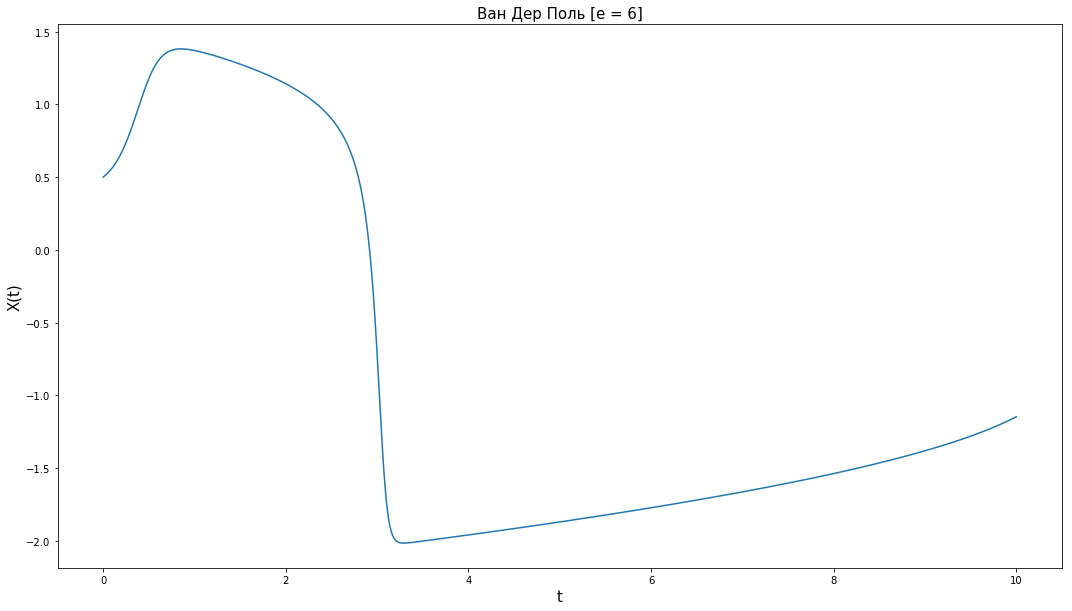

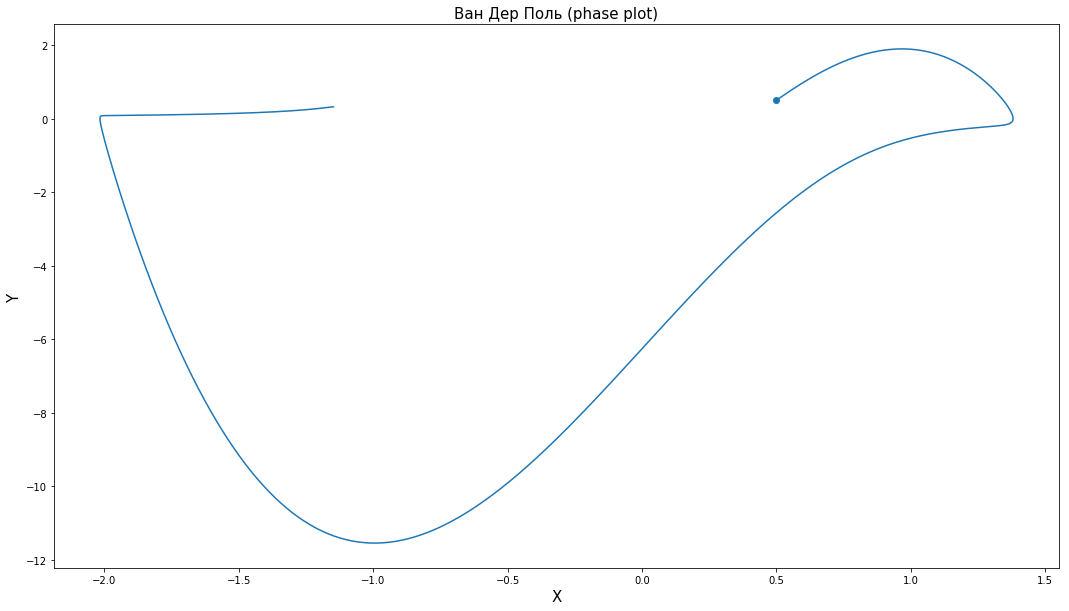

In [169]:
wonder.build( (8, 0), (0.5, 0.5), np.linspace(0, 10, 10000))
wonder.plot('Ван Дер Поль','[e = 6]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

In [ ]:
wonder.build( (-1, 0), (0.5,0.5), np.linspace(0, 250, 500))
wonder.plot('Ван Дер Поль','[\u03BC = -1]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

In [ ]:
wonder.build( (0.5, 0), (0.5,0.5), np.linspace(0, 250, 50000))
wonder.plot('Ван Дер Поль','[\u03BC = 0.5]')
wonder.phase_plot('Ван Дер Поль')

### Display values

In [ ]:
#pd.set_option('display.max_rows', 999)
#For displaying X(t) and Y(t)
#pd.merge(wonder.get_data(0), wonder.get_data(1), on = 't')

In [ ]:
def brussellator(z, t, a, b):
    dx_dt = a + z[1] * z[0]**2 - b * z[0] - z[0]
    dy_dt = b * z[0] - z[1] * z[0]**2
    return dx_dt, dy_dt
brussel = Model(brussellator)
brussel_params = {
    'a': 1, 
    'b': 2.3
}
brussel_initial_condition=(0, 0.1)
brussel_time_points=np.arange(0, 50, 0.1)
brussel.build((1, 1.7), brussel_initial_condition, brussel_time_points)
brussel.plot('Brusselator', str(brussel_params.values()))
brussel.phase_plot('Brusselator')

<Figure size 432x288 with 0 Axes>

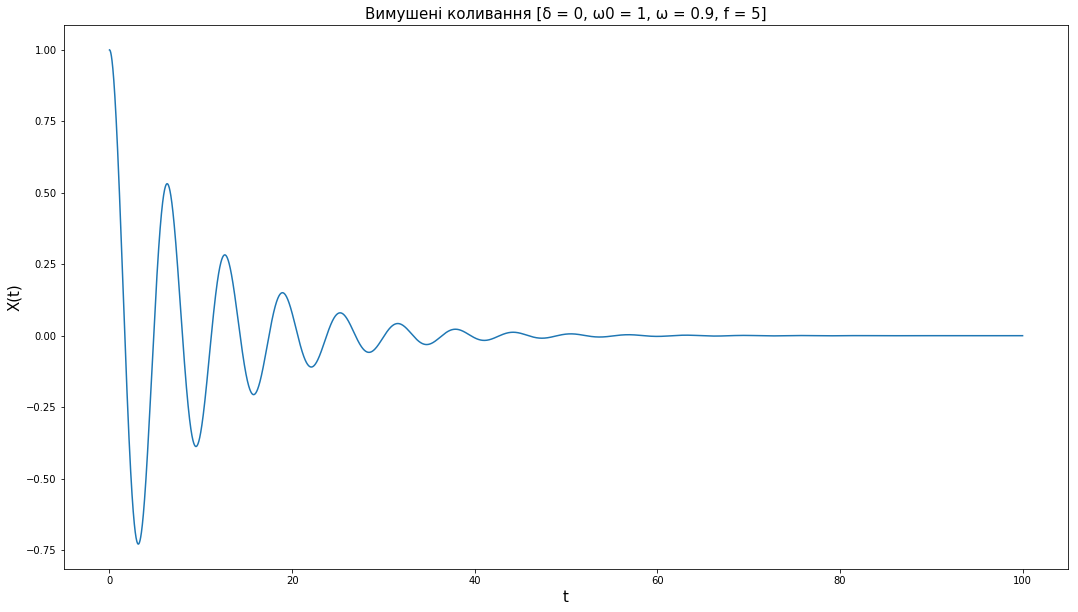

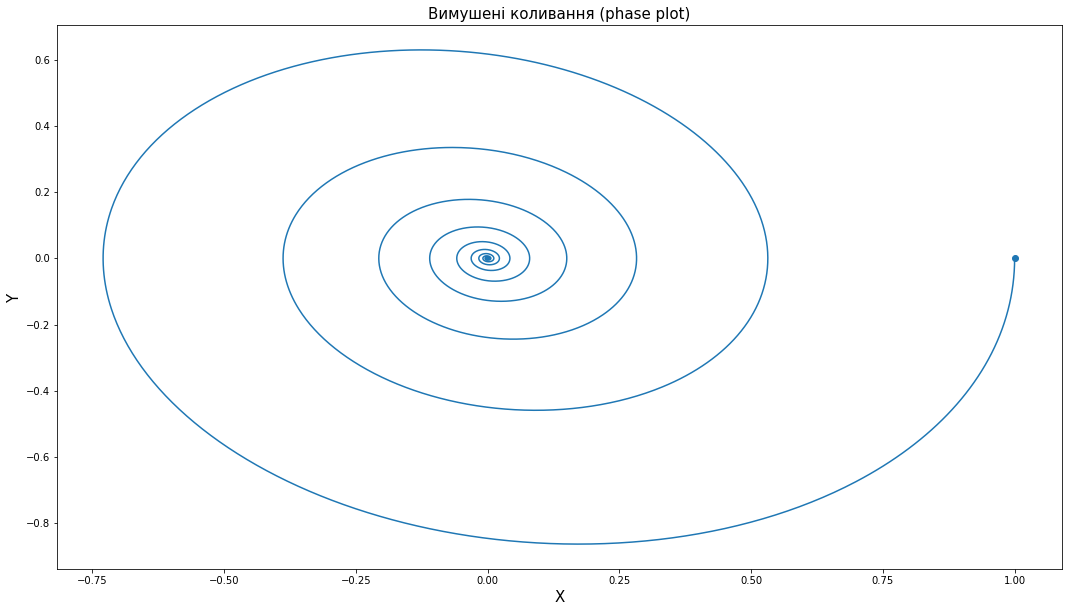

In [40]:
def oscilation(z, t, delta, omega_0, omega, f):
    dx_dt = z[1]
    dy_dt = 2 * delta * z[1] - omega_0 ** 2 * z[0] - f * np.cos(omega * t)  
    return dx_dt, dy_dt

oscilate = Model(oscilation)
oscilate.build((-0.1, 1, 0, 0), (1,0), np.linspace(0, 100, 10000))
oscilate.plot('Вимушені коливання', '[\u03B4 = 0, \u03C90 = 1, \u03C9 = 0.9, f = 5]')
oscilate.phase_plot('Вимушені коливання')

# LAB 2

In [ ]:
def Verhulst(z, t, r, k):
    dx_dt = r * z[0] * (k - z[0])
    dy_dt = 0 
    return dx_dt, dy_dt

verhulst = Model(Verhulst)

verhulst.build( (0.1, 100), (0.1,0), np.linspace(0, 0, 1000))

y = verhulst.get_values(50)
funcs = [lambda x: x, lambda x: x ** 2]
settings = (0, 10, 1)
orders = [1, 1, 1]
data = form_discrete_values(settings, funcs, y, orders)

In [26]:
delta = 0.1
omega = 0.5
settings = (0, 10, 1)
oscilate = Model(oscilation)
start = 0
end = 400
iters = 40000
step = 100
oscilate.build((-delta, omega, 0, 0), (1,0), np.linspace(start, end, iters))
y = oscilate.get_values(step)
h = (end - start)*step/iters
print(h)
print(omega)
orders = [3, 2, 1]
teta_1 = (omega ** 2 - 2 + 2 * delta) / (2 * delta - 1)
funcs = [lambda x: x, lambda x: x, lambda x: x]
data = form_discrete_values(settings, funcs, y, orders, h)
params = oscilate.get_params(data)
delta = (1. / (2*h) ) * ((params[0]) + 1)
omega = ((params[1] * (2 * h * delta - 1) + (2 - 2 * h * delta)) ** 0.5) * (1. / h)
#print(delta)
#print(np.sqrt(params[0] * (2 * delta - 1) + 2 - 2 * delta))
omega
delta

1.0
0.5
(1,)
(2,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Example of how the code works with dummy data

In [190]:
X = np.array([[np.random.uniform(0, 1) for j in range(10)] for i in range(100)])
Y = np.array([[np.random.uniform(0, 1)] for i in range(100)])
np.linalg.lstsq(X, Y)[0]

oscilate = Model(oscilation)
data = np.hstack((X, Y))
solver = Approximator(data)
tetas = solver.get_tetas(9)
variance = solver.get_variance()
mallows = solver.get_Mallows()
akaike = solver.get_Akaike()
print(tetas)
print("variance is " + str(variance))
print("Mallows is " + str(mallows))
print("Akaike is " + str(akaike))

variance is 13.487138693708198
[[4.21486148]]
[[2.0924648]]
[[1.49114047]]
[[1.26392781]]
[[0.61992651]]
[[0.4619933]]
[[0.46097545]]
[[0.23834809]]
[ 0.1129903   0.19120692  0.18426417  0.01011861  0.17187599  0.08669259
 -0.02514449  0.13959838  0.09089028]
variance is [[0.23834809]]
Mallows is [[0.02945875]]
Akaike is [[0.2972656]]


In [1]:
# blabla